# Data Visualization - Mapping Membership
Please take a look at the readme for more details on the context behind the project! Throughout the notebook, there are comments to explain my thinking/code.

**Important Notes:** 
- The data used in this project is sample data in CSVs. In the original project, the data was sourced directly from Civis, a platform used by some progressive non-profits to conduct their analytics, layered on top of a Redshift instance. Any cells fully commented out with a #s are the original query (with the API key redacted) for visibility. 

- This was an exploratory notebook. All charts and insights were pulled out into a deck and presented to leadership.

- Chapters are the physical "clubs" of the organization. Chapters each have a lead and some members. Member recruits are folks who have indicated they want to join a chapter, but haven't yet. Supporters are general supporters of the organization that have not indicated they want to join a chapter. 

- Some outputs have been cleared to shrink the size of the notebook file.

### Building the desired visualization in Folium
I needed to test the map out and see what would look best. The next few cells are aggregating data that will be used in the final product, placed on a test map to adjust appropriately as needed -- before pulling everything for a final visualization. 

In [1]:
# import civis
# 
# query = """SELECT m.*, a.*
# FROM m4ol_ea.tsm_tmc_events_mfol m
# INNER JOIN m4ol_ea.tsm_tmc_eventslocations_mfol l ON l.eventid = m.eventid
# INNER JOIN m4ol_ea.tsm_tmc_locations_mfol a ON a.locationid = l.locationid
# WHERE m.eventcalendarname LIKE '%Community Chapter%' OR 
# m.eventcalendarname LIKE '%HS chapter%' OR m.eventcalendarname LIKE '%College Chapter%'"""

# key = 'api_key'

# nchapters = civis.io.read_civis_sql(query, 'TMC', use_pandas=True, api_key = key)
# nchapters.columns

In [2]:
import os
import pandas as pd
import requests
import io

url = "https://raw.githubusercontent.com/tejgokhale/portfolio/main/membership_visualization/data/example_chapter_data.csv"
data = requests.get(url).content

# All current chapters (clubs) of the organization
nchapters = pd.read_csv(io.StringIO(data.decode('utf-8')))

In [3]:
import folium

mapper = folium.Map(location = [37, -92], zoom_start=4, tiles='CartoDB dark_matter')

# Testing out the map settings to see if it looks the way I want it to
mapper

In [4]:
# All current chapters that have a location
c = nchapters[nchapters['latitude'].notnull()]

In [5]:
# Marking chapters on the map, tested out different settings to find the best way to present a chapter

for i in range(0, len(c)):
    folium.CircleMarker(location = [c.iloc[i]['latitude'], c.iloc[i]['longitude']], popup = c.iloc[i]['eventname'] 
                   ).add_to(mapper)

mapper

In [6]:
# query = """
# SELECT mt.*, m.datecreated::date, el.dateunsubscribed::date
# FROM m4ol_ea.tsm_tmc_contactsactivistcodes_mfol m
# INNER JOIN m4ol.chapter_codes c ON c.id = m.activistcodeid
# LEFT JOIN m4ol_ea.tsm_tmc_contactsaddresses_mfol mt ON mt.vanid = m.vanid
# LEFT JOIN m4ol_ea.tsm_tmc_contactsemails_mfol e ON e.vanid = m.vanid
# INNER JOIN m4ol_ea.tsm_tmc_emailsubscriptions_mfol el ON el.email = e.email
# """
#
# supporters = civis.io.read_civis_sql(query, 'TMC', use_pandas=True, api_key = key)
# supporters.columns

In [7]:
# All chapter member recruits of the organization that we have information on

url = "https://raw.githubusercontent.com/tejgokhale/portfolio/main/membership_visualization/data/supporters.csv"
data = requests.get(url).content

supporters = pd.read_csv(io.StringIO(data.decode('utf-8')))

In [8]:
# Maps zip codes to latitude & longitude for tables that only have zip info - lat/long needed for mapping

url = "https://raw.githubusercontent.com/tejgokhale/portfolio/main/membership_visualization/data/zips.csv"
data = requests.get(url).content

zips = pd.read_csv(io.StringIO(data.decode('utf-8')))

In [9]:
# zips = civis.io.read_civis('m4ol.zips_lat_long', 'TMC', use_pandas = True, api_key = key)
# zips.columns

In [10]:
# Getting lat/long info for all chapter member recruits and only including unique chapter member recruits

print(supporters.shape)
supporters_coords = supporters.merge(zips, how='left', left_on = 'zip5', right_on = 'zip')
supporters_coords = supporters_coords[supporters_coords['vanid'].notnull()]
supporters_coords['vanid'] = supporters_coords['vanid'].astype(int)
supporters_coords = supporters_coords.drop_duplicates(subset = ['vanid'])
print(supporters_coords.shape)

(6000, 8)
(482, 17)


In [11]:
# Grouping chapter member recruits by the year they joined

import pandas as pd
supporters_coords['datecreated'] = pd.to_datetime(supporters_coords['datecreated'])

In [12]:
import datetime

for index,row in supporters_coords.iterrows():
    if(row['datecreated'] < datetime.datetime(2020, 1, 1)):
        supporters_coords.loc[index, 'year'] = datetime.date(2019,1,1)
    elif((row['datecreated'] >= datetime.datetime(2020,1,1)) & (row['datecreated'] <= datetime.datetime(2020,12,31))):
        supporters_coords.loc[index,'year'] = datetime.date(2020,1,1)
    else:
        supporters_coords.loc[index,'year'] = datetime.date(2021,1,1)

supporters_coords['year'].value_counts()

2019-01-01    339
2020-01-01     91
2021-01-01     52
Name: year, dtype: int64

In [13]:
supporters_coords['latitude_y'].isnull().sum()

81

In [14]:
# Looking at how many chapter member recruits have unsubscribed from email/SMS by year

unsubs = supporters_coords[supporters_coords['dateunsubscribed'].notnull()]
unsubs['year'].value_counts()

2019-01-01    51
2020-01-01    12
2021-01-01     5
Name: year, dtype: int64

In [15]:
supporters_coords = supporters_coords[supporters_coords['latitude_y'].notnull()]

In [16]:
# Mapping chapter member recruits with a jitter to protect privacy of supporters. 

import random

for i in range(0, len(supporters_coords)):
    folium.CircleMarker(location = [supporters_coords.iloc[i]['latitude_y']+random.random()/1000, supporters_coords.iloc[i]['longitude_y'] + random.random()/1000], 
                   radius=0.5, color="#164686").add_to(mapper)

mapper

### Pulling the rest of the data & building the final maps
Now that the map looks like I want it to (the chapters represented with circles with a sizable enough radius to see from afar) and supporters with dots, it's time to grab the rest of the data and build the final maps.

In [17]:
# query = """
# SELECT mt.*, m.activistcodeid
# FROM m4ol_ea.tsm_tmc_contactsactivistcodes_mfol m
# LEFT JOIN m4ol_ea.tsm_tmc_contactsaddresses_mfol mt ON mt.vanid = m.vanid
# WHERE m.activistcodeid in (4794200, 4794201, 4801932, 4801933)
# """

# members = civis.io.read_civis_sql(query, 'TMC', use_pandas=True, api_key = key)

In [18]:
# All chapter leads and chapter members

url = "https://raw.githubusercontent.com/tejgokhale/portfolio/main/membership_visualization/data/members.csv"
data = requests.get(url).content

members = pd.read_csv(io.StringIO(data.decode('utf-8')))

In [19]:
# Chapter leads of the organization

chapter_leads = members[members['activistcodeid'] == 4801932]
chapter_leads.drop_duplicates(subset = 'vanid', inplace=True)

<ipython-input-19-82ca710758d7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chapter_leads.drop_duplicates(subset = 'vanid', inplace=True)


In [20]:
# Adding lat/long info to the chapter leads data, removing chapter leads that don't have a location

chapter_leads.shape
chapter_leads = chapter_leads.merge(zips, how = 'left', left_on = 'zip5', right_on = 'zip')
chapter_leads.shape

(22, 15)

In [21]:
chapter_leads = chapter_leads[chapter_leads['latitude_y'].notnull()]

In [22]:
# Same as chapter leads, adding lat/long info and removing members that don't have a location

chapter_members = members[members['activistcodeid'] == 4801933]
chapter_members.drop_duplicates(subset = 'vanid', inplace=True)
chapter_members = chapter_members.merge(zips, how='left', left_on = 'zip5', right_on = 'zip')
chapter_members = chapter_members[chapter_members['latitude_y'].notnull()]
print(chapter_members.shape)

(60, 15)


<ipython-input-22-e4a2c5627350>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chapter_members.drop_duplicates(subset = 'vanid', inplace=True)


In [23]:
# The outdated version of chapters (inactive ones)

url = "https://raw.githubusercontent.com/tejgokhale/portfolio/main/membership_visualization/data/old_chapters_sample.csv"
data = requests.get(url).content

old = pd.read_csv(io.StringIO(data.decode('utf-8')))
old.shape

(10, 2)

In [24]:
# Separating out lat/long info from the details field of old

locs = old['location'].str.split(pat = '"', expand=True)

In [25]:
# Building the dataframe again with just chapter name and lat/long info

old_chapters = pd.concat([old['chapter'], locs[[7,11]]], axis=1)

In [26]:
old_chapters.rename({7:'lat'}, inplace=True, axis=1)
old_chapters.rename({11:'long'}, inplace=True, axis=1)
old_chapters

,chapter,lat,long
0,MFOL American University,38.94570119999999,-77.08126909999999
1,"MFOL Annapolis, MD",38.97844529999999,-76.49218289999999
2,MFOL Austin,30.267153,-97.74306079999997
3,MFOL Bakersfield,35.3732921,-119.01871249999999
4,MFOL Bergen County,40.9262762,-74.07700999999997
5,"MFOL Yorba Linda HS, CA",33.89877190000001,-117.79019790000001
6,MFOL Binghamton University,42.0893553,-75.96970490000001
7,"MFOL Wilmington, NC",34.2103894,-77.88681170000001
8,MFOL Boston,42.3600825,-71.05888010000001
9,"MFOL Sir Francis Drake HS, CA",37.983914,-122.573328


In [27]:
# query = """SELECT a.*
# FROM m4ol_ea.tsm_tmc_eventsignups_mfol s 
# INNER JOIN m4ol_ea.tsm_tmc_events_mfol e ON s.eventid = e.eventid
# INNER JOIN m4ol.all_van_info_matched m ON m.vanid = s.vanid
# INNER JOIN m4ol_ea.tsm_tmc_contacts_mfol c ON c.vanid = s.vanid
# LEFT JOIN m4ol_ea.tsm_tmc_contactsaddresses_mfol a ON a.vanid = s.vanid
# WHERE (s.datetimeoffsetbegin :: date) >= '2021-01-01' AND (c.dob > '1996-01-01' or m.vb_voterbase_age <= 25)"""

# events2021 = civis.io.read_civis_sql(query, 'TMC', use_pandas=True, api_key = key)
# events2021.columns

In [28]:
# All young people who have attended an MFOL event in 2021

url = "https://raw.githubusercontent.com/tejgokhale/portfolio/main/membership_visualization/data/event_attendees.csv"
data = requests.get(url).content

events2021 = pd.read_csv(io.StringIO(data.decode('utf-8')))

In [29]:
events2021.drop_duplicates(subset='vanid', inplace=True)
events2021.shape

(500, 15)

In [30]:
events2021 = events2021.merge(zips, how='left', left_on = 'zip5', right_on = 'zip')

In [31]:
events2021_ = events2021[events2021['latitude_y'].notnull()]
events2021_.shape

(462, 24)

In [32]:
# all_folks = civis.io.read_civis('m4ol.update_youth_supporters', 'TMC', use_pandas=True, api_key = key)

In [33]:
# All people that we have information on (all supporters)

url = "https://raw.githubusercontent.com/tejgokhale/portfolio/main/membership_visualization/data/all_supporters.csv"
data = requests.get(url).content

all_folks = pd.read_csv(io.StringIO(data.decode('utf-8')))

In [34]:
all_f = all_folks[all_folks['zip5'].notnull()]
all_f.shape

(48923, 4)

In [35]:
# Specific cleaning to ensure the data will merge properly with zips

all_f['zip5'].replace('90,75',0, inplace=True)
all_f['zip5'] = all_f['zip5'].astype(int)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
<ipython-input-35-b47d2888d643>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_f['zip5'] = all_f['zip5'].astype(int)


In [36]:
all_f = all_f.merge(zips, how='left', left_on = 'zip5', right_on='zip')
all_f.shape

(48923, 13)

In [37]:
all_f.drop_duplicates(subset='vanid', inplace=True)
all_f.shape

(8885, 13)

In [38]:
all_f['latitude'].isnull().sum()

191

In [39]:
all_f['dateunsubscribed'].notnull().sum()

3092

In [40]:
all_f = all_f[all_f['latitude'].notnull()]

In [41]:
all_f['datecreated'] = pd.to_datetime(all_f['datecreated'])

In [42]:
all_f['year'] = all_f.datecreated.apply(lambda x: datetime.date(2019, 1, 1) if x < datetime.datetime(2020, 1, 1)
                                       else(datetime.datetime(2021,1,1) if x > datetime.datetime(2020,12,31) else 
                                           datetime.datetime(2020,1,1)))

all_f['year'].value_counts()

2019-01-01    7263
2021-01-01     899
2020-01-01     532
Name: year, dtype: int64

In [43]:
all_f.rename({'latitude': 'latitude_y', 'longitude': 'longitude_y'}, axis=1, inplace=True)

In [44]:
# Function to jitter all data points to plot points that map on the same location in and around each other

def random_coords(df):
    df['new_lat'] = df.latitude_y.apply(lambda x: x + random.random()/1000)
    df['new_long'] = df.longitude_y.apply(lambda x: x +random.random()/1000)

In [45]:
random_coords(chapter_leads)
random_coords(chapter_members)
random_coords(events2021_)
random_coords(all_f)
random_coords(supporters_coords)

<ipython-input-44-26f39158c450>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['new_lat'] = df.latitude_y.apply(lambda x: x + random.random()/1000)
<ipython-input-44-26f39158c450>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['new_long'] = df.longitude_y.apply(lambda x: x +random.random()/1000)


In [ ]:
# BUILDING THE FINAL MAP
# Each dataframe has its own FeatureGroup, an attribute that allows us to unselect and deselect as a layer on the map
# This is built on top of a new map than the original test map

from folium.map import *

chapters = folium.Map(location = [37, -92], zoom_start=4, tiles='CartoDB dark_matter')

# Creating a feature group for each dataset
youngs = FeatureGroup(name='Youth Advocates (All Time)')
chapters_2021 = FeatureGroup(name='Chapters (2021)')
chapter_leads_2021 = FeatureGroup(name='Chapter Leads (2021)')
chapter_members_2021 = FeatureGroup(name='Chapter Members (2021)')
chapter_members_events_2021 = FeatureGroup(name='Youth Attendees for Events (2021)')
old_chapt = FeatureGroup(name = 'Chapters (2018-2020)')
rec = FeatureGroup(name = 'Chapter Member Recruits (All Time)')

# Plotting all the datasets

for i in range(0, len(c)):
    chapters_2021.add_children(folium.CircleMarker(location = [c.iloc[i]['latitude'], c.iloc[i]['longitude']], 
                                                   popup = c.iloc[i]['eventname'])) 
                   
for i in range(0, len(chapter_leads)):
    chapter_leads_2021.add_children(folium.CircleMarker(location = [chapter_leads.iloc[i]['new_lat'], 
                                                                    chapter_leads.iloc[i]['new_long']], 
                   radius=0.5, color="#2892fa"))

for i in range(0, len(chapter_members)):
    chapter_members_2021.add_children(folium.CircleMarker(location = [chapter_members.iloc[i]['new_lat'], 
                                                                      chapter_members.iloc[i]['new_long']], 
                   radius=0.5, color="#ff7943"))

for i in range(0, len(old_chapters)):
    old_chapt.add_children(folium.CircleMarker(location = [old_chapters.iloc[i]['lat'], old_chapters.iloc[i]['long']], 
                        color="#a9a9a9", popup = old_chapters.iloc[i]['chapter']))   

for i in range(0, len(events2021_)):
    chapter_members_events_2021.add_children(folium.CircleMarker(location = [events2021_.iloc[i]['new_lat'], 
                                                                    events2021_.iloc[i]['new_long']], 
                   radius=0.5, color="#ff7943"))

for i in range(0, len(supporters_coords)):
    rec.add_children(folium.CircleMarker(location = [supporters_coords.iloc[i]['new_lat'], supporters_coords.iloc[i]['new_long']], 
                   radius=0.5, color="#ff00ff"))

for i in range(0, len(all_f)):
    youngs.add_children(folium.CircleMarker(location = [all_f.iloc[i]['new_lat'], 
                                                                    all_f.iloc[i]['new_long']], 
                   radius=0.5, color="#164686"))

# Adding all the FeatureGroups to the final map
    
chapters.add_children(chapter_leads_2021)
chapters.add_children(chapter_members_2021)
chapters.add_children(chapter_members_events_2021)
chapters.add_children(rec)
chapters.add_children(youngs)
chapters.add_children(chapters_2021)
chapters.add_children(old_chapt)
chapters.add_children(folium.map.LayerControl())
chapters

This map was the first time that MFOL leadership had a chance to understand the size, scale, and geographic placement of our volunteer network. It provided stakeholders with a chance to fully understand where to invest resources and how to think about the larger group of supporters that weren't in chapters. 

In [47]:
# Saving the map to a separate file for people to play around with outside the notebook

# chapters.save('full_membership_example.html')

In [48]:
# As an example of deeper analysis - I decided to look at how many supporters & members live outside a 15 mile 
# radius of a chapter. Chapters were the main way of engaging supporters for the organization, but I had a hunch
# most supporters couldn't access a chapter based on their location.

In [49]:
import numpy as np

# Function to calculate the distance between each supporter/member and their closest chapter by lat/long.
# Code for function taken from here: https://dadoverflow.com/2022/01/07/pandas-and-distance-calculations/

def haversine_vectorize(lon1, lat1, lon2, lat2):

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    newlon = lon2 - lon1
    newlat = lat2 - lat1

    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2

    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    km = 6367 * dist #6367 for distance in KM for miles use 3958
    return km

In [50]:
# Applying the function and if they are outside a 15 mile radius (24km), setting the flag to remove to True

supporters_coords['remove_flag'] = False

for index, row in c.iterrows():
    supporters_coords['temp_dist'] = haversine_vectorize(row['longitude'], row['latitude'], supporters_coords['new_long'], supporters_coords['new_lat'])
    supporters_coords['remove_flag'] = supporters_coords['remove_flag'].where(supporters_coords['temp_dist']>24, other = True)

In [51]:
supporters_coords['remove_flag'].value_counts()

False    386
True      15
Name: remove_flag, dtype: int64

In [52]:
all_f['remove_flag'] = False
for index, row in c.iterrows():
    all_f['temp_dist'] = haversine_vectorize(row['longitude'], row['latitude'], all_f['new_long'], all_f['new_lat'])
    all_f['remove_flag'] = all_f['remove_flag'].where(all_f['temp_dist']>24, other = True)

In [53]:
all_f['remove_flag'].value_counts()

False    8377
True      317
Name: remove_flag, dtype: int64

In [54]:
notins = all_f[all_f['remove_flag'] == False]
ins = all_f[all_f['remove_flag'] == True]
notincr = supporters_coords[supporters_coords['remove_flag'] == False]
incr = supporters_coords[supporters_coords['remove_flag'] == True]

In [ ]:
# BUILDING THE FINAL MAP
# Each dataframe has its own FeatureGroup, an attribute that allows us to unselect and deselect as a layer on the map
# This is built on top of another map than the other map

radius_map = folium.Map(location = [37, -92], zoom_start=4, tiles='CartoDB dark_matter')

# Creating a feature group for each dataset
chpt = FeatureGroup(name='Chapters (2021)')
fullrec = FeatureGroup(name = 'Chapter Member Recruits - Inside Radius')
notinrec = FeatureGroup(name = 'Chapter Member Recruits - Outside Radius')
fullyoung = FeatureGroup(name='Youth Advocates - Inside Radius')
notinyoung = FeatureGroup(name = 'Youth Advocates - Outside Radius')

# Plotting all the datasets

for i in range(0, len(c)):
    chpt.add_children(folium.CircleMarker(location = [c.iloc[i]['latitude'], c.iloc[i]['longitude']], 
                                                   popup = c.iloc[i]['eventname'])) 

for i in range(0, len(incr)):
    fullrec.add_children(folium.CircleMarker(location = [incr.iloc[i]['new_lat'], incr.iloc[i]['new_long']], 
                   radius=0.5, color="#ff00ff"))

for i in range(0, len(ins)):
    fullyoung.add_children(folium.CircleMarker(location = [ins.iloc[i]['new_lat'], 
                                                                    ins.iloc[i]['new_long']], 
                   radius=0.5, color="#164686"))

for i in range(0, len(notins)):
    notinyoung.add_children(folium.CircleMarker(location = [notins.iloc[i]['new_lat'], notins.iloc[i]['new_long']], 
                   radius=0.5, color="#164686"))

for i in range(0, len(notincr)):
    notinrec.add_children(folium.CircleMarker(location = [notincr.iloc[i]['new_lat'], 
                                                                    notincr.iloc[i]['new_long']], 
                   radius=0.5, color="#ff00ff"))

# Adding all the FeatureGroups to the final map

radius_map.add_children(fullrec)
radius_map.add_children(notinrec)
radius_map.add_children(fullyoung)
radius_map.add_children(notinyoung)
radius_map.add_children(chpt)
radius_map.add_children(folium.map.LayerControl())
radius_map

As we can see from this map, playing around with the layers, almost all members and supporters live outside a 15 mile radius from a chapter. This exposed the need for the organization to scale up its engagement tactics outside of funneling new people into chapters, since so many lived so far away from their nearest chapter. 

In [56]:
# Saving the map to a separate file for people to play around with outside the notebook

# radius_map.save('radius_example.html')

In [57]:
# BONUS VISUALIZATION
# To further demonstrate the size of the supporter base outside of chapters, used a waffle chart.

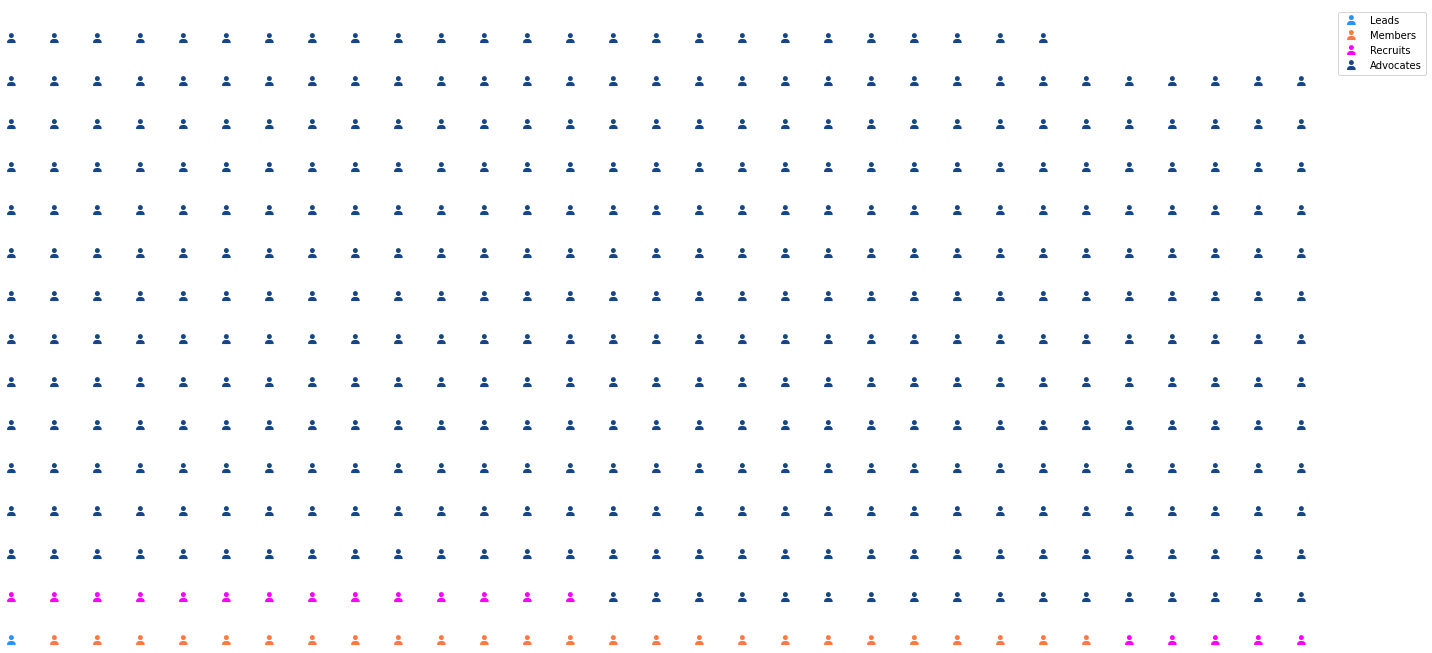

In [58]:
import matplotlib.pyplot as plt
from pywaffle import Waffle

denom = chapter_leads.shape[0]
mems = (chapter_members.shape[0] + events2021_.shape[0])/denom
recruits = supporters_coords.shape[0]/denom
advocates = all_f.shape[0]/denom
data = {'Leads': 1, 'Members': mems, 
        'Recruits': recruits, 'Advocates': advocates }

fig = plt.figure(
    FigureClass=Waffle, 
    rows=15, figsize = (20,20), 
    values=data, 
    colors=("#2892fa", "#ff7943", "#ff00ff", "#164686"),
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    icons='user', icon_size=10, 
    icon_legend=True, vertical = True
)